In [ ]:
!pip install facenet-pytorch
!pip install -U albumentations
from PIL import Image
from facenet_pytorch.models.mtcnn import MTCNN
from google.colab.patches import cv2_imshow
from random import randint
import random
import zipfile
import cv2
import dlib
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import albumentations as A
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 5.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def blackout_eyes(img, boxes, landmarks):
  left_eye_x, left_eye_y = landmarks[0][0][0], landmarks[0][0][1]
  right_eye_x, right_eye_y = landmarks[0][1][0], landmarks[0][1][1]

  box_width, box_height = boxes[0][2]*0.8, boxes[0][3]*0.1              
  #defining width and height of black rectangle to be created
  width_margin, height_margin = 0.1*box_width, box_height*0.4
  ## old--->> width_margin, height_margin = abs(left_eye_x - right_eye_x)*0.25, 10
  #width_margin, height_margin = width*0.8, box_height*0.1
  if(landmarks[0][0][1] >= landmarks[0][1][1]):
    start = (math.ceil(left_eye_x - width_margin), math.ceil(left_eye_y - height_margin))
    end = (math.ceil(right_eye_x + width_margin), math.ceil(right_eye_y + height_margin))
  else:
    end = (math.ceil(left_eye_x - width_margin), math.ceil(left_eye_y - height_margin))
    start = (math.ceil(right_eye_x + width_margin), math.ceil(right_eye_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img

def blackout_nose(img, boxes, landmarks):
  nose_x, nose_y = landmarks[0][2][0], landmarks[0][2][1]
  box_width, box_height = boxes[0][2]*0.8, boxes[0][3]*0.1
  width_margin, height_margin = 0.15*box_width, box_height*0.5
  start = (math.ceil(nose_x - width_margin), math.ceil(nose_y - height_margin*1.5))
  end = (math.ceil(nose_x + width_margin), math.ceil(nose_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img

def blackout_mouth(img, boxes, landmarks):
  left_mouth_x, left_mouth_y = landmarks[0][3][0], landmarks[0][3][1]
  right_mouth_x, right_mouth_y = landmarks[0][4][0], landmarks[0][4][1]
  box_width, box_height = boxes[0][2]*0.5, boxes[0][3]*0.15
  #defining width and height of black rectangle to be created
  width_margin, height_margin = 0.1*box_width, box_height*0.35
  ## old--->> width_margin, height_margin = abs(left_eye_x - right_eye_x)*0.25, 10
  #width_margin, height_margin = width*0.8, box_height*0.1
  start = (math.ceil(left_mouth_x - width_margin), math.ceil(left_mouth_y - height_margin))
  end = (math.ceil(right_mouth_x + width_margin), math.ceil(right_mouth_y + height_margin))
  cv2.rectangle(img, start, end, (0,0,0),-1)
  return img 

In [ ]:
def blackout(img, boxes, probs, landmarks):
  if not probs[0]:     #incase no face detected by MTCNN
    return img

  if probs[0] < 0.95:  #in case MTCNN not sure about exact face landmarks, can be due to blurring
    return img

  m = randint(0, 3)  ##Random number
  
  if m==0:
    return blackout_eyes(img, boxes, landmarks)
  
  elif m==1:
    return blackout_nose(img, boxes, landmarks)

  else:
    return blackout_mouth(img, boxes, landmarks)

In [ ]:
def mtcnn_params(img):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)
    return boxes, probs, landmarks

####Defining the path for various folders

In [ ]:
celebA_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-CelebA"
ffhq_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-FFHQ"
attgan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-ATTGAN"
gdwct_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-GDWCT"
stylegan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-STYLEGAN"
stylegan2_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-STYLEGAN2/1-STYLEGAN2"
stargan_path = "/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/1-StarGAN"

####Seems we can't directly save the folder (that you created), so read the saving part carefully. Also **don't keep any spaces** in the name of folder you have created to store the augmented images.

####Applying Transformation to CelebA images

In [ ]:
path=stargan_path + "/"  #The path from which we want to read the images---> change accordingly
files=os.listdir(path)  #Gives list of all files(images) in that folder--->no change required
COUNT = 1 # this variable will be used in naming of augmented images while saving--->no change required

for file in files:  #no change required for these 5 lines
  img = cv2.imread(path + f"{file}")  #reading the file
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) NO NEED TO CONVERT BGR TO RGB
  boxes, probs, landmarks = mtcnn_params(img)  #getting landmarks of face
  new_img = blackout(img, boxes, probs, landmarks) #applying blackout on the image

#-------------Augmenting images from the blackout image we just created-------------------------------------------#

  for i in range(6):  # 3--> for real, 6--> for deepfake

#------------applying transformations using Albumentations (Main Transform pipeline)-------------------------------#
#--------------------only this part of code will be different for Keras Team---------------------------------------#

    transform = A.Compose([   #Change the pipeline to what you feel best suits your folder. Avoid too much augmentations
      A.Resize(160, 160, p=1),
      A.ImageCompression(quality_lower = 70, quality_upper=100, p=0.7),
      A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
      A.Flip(p = 0.6),

      A.OneOf([
        A.GaussianBlur(blur_limit=3, sigma_limit=0, p=0.7),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.3),
      ], p = 0.6),

      A.OneOf([
        A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.7),
        A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.3),
      ], p = 0.7),

      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.25),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.25), 
      ], p = 0.5),  

    ], p = 0.9)
#-------------------------applying transform on blackout img-----------------------------------------------#

    aug = transform(image = new_img)["image"]  #the augmented image-->no change required
    
#-------------------------SAVING EACH IMAGE TO 'CelebA_Augmented' FOLDER-------------------------------------#

    folder_to_save_img = "/content/drive/MyDrive/StarGan_Augmented"  #Path of folder you created  ---> Change this accordingly
    name_of_augmented_file = f"0_StarGAN_{COUNT}.jpg"  #Naming convention to be followed --> Change this accordingly, only 0/1 and celebA to be changed
    
    cv2.imwrite(f"{folder_to_save_img}/{name_of_augmented_file}", aug) #saving the augmented image--> no change required
    COUNT+=1 #updating the count of img-->no change required




####Experimenting with random images before deciding parameter values and probabilities for the main transform pipeline

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-CelebA/000502.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("/content/drive/MyDrive/Omdena DeepFake Image Detection (preprocessed data)/Train/0-FFHQ/00501.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


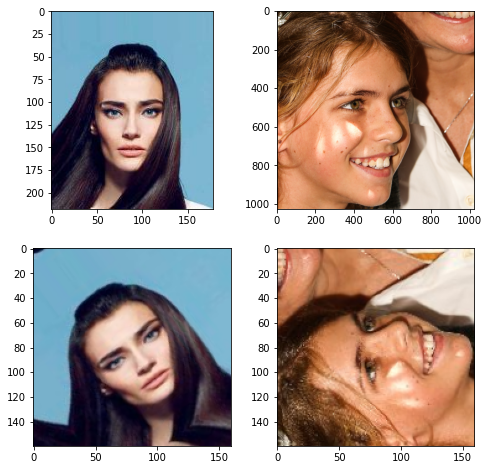

In [ ]:
transform = A.Compose([
    A.Resize(160, 160, p=1),
    A.ImageCompression(quality_lower = 70, quality_upper=100, p=1),
    
    #A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=1),
    A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=1),
    
    #A.Affine(scale = None, translate_percent= 0.1, shear = (10,10), p=1),
    # A.Flip(p=1),
    # A.Affine(scale = 1.4, translate_percent= None, shear = None, p=1),
    #A.MedianBlur(blur_limit=3, always_apply=False, p=1),
    #A.GaussianBlur(blur_limit=3, sigma_limit=0, p=1),
    #A.GaussNoise(p=1),
    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=1)    
])
aug1 = transform(image = img1)["image"]
aug2 = transform(image = img2)["image"]
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.imshow(img2)
plt.subplot(2,2,3)
plt.imshow(aug1)
plt.subplot(2,2,4)
plt.imshow(aug2)

In [ ]:
#shows difference in size/space image occupies before and after compression
import sys
print(sys.getsizeof(img1),sys.getsizeof(img2),sys.getsizeof(aug1),sys.getsizeof(aug2))

116556 3145872 76944 76944


###Trying Entire procedure(blackout + transform) on each folder to check outcome. Must do before generating and saving augmented images!

In [ ]:
#Main transform pipeline
transform = A.Compose([
  A.Resize(160, 160, p=1),
  A.ImageCompression(quality_lower = 70, quality_upper=100, p=0.8),
  A.GaussNoise(p=0.6),
  A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
  A.Flip(p = 0.6),

  A.OneOf([
    A.GaussianBlur(blur_limit=3, sigma_limit=0, p=0.7),
    A.MedianBlur(blur_limit=3, always_apply=False, p=0.3),
  ], p = 0.8),

  A.OneOf([
    A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.65),
    A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.35),
  ], p = 0.7),

  A.OneOf([
    A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
    A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.25),
    A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.25), 
  ], p = 0.6),  
    
], p = 0.9)

####CelebA

/content/CelebA_Augmented/0_CelebA_1.jpg
/content/CelebA_Augmented/0_CelebA_2.jpg
/content/CelebA_Augmented/0_CelebA_3.jpg
/content/CelebA_Augmented/0_CelebA_4.jpg
/content/CelebA_Augmented/0_CelebA_5.jpg
/content/CelebA_Augmented/0_CelebA_6.jpg
/content/CelebA_Augmented/0_CelebA_7.jpg
/content/CelebA_Augmented/0_CelebA_8.jpg
/content/CelebA_Augmented/0_CelebA_9.jpg
/content/CelebA_Augmented/0_CelebA_10.jpg


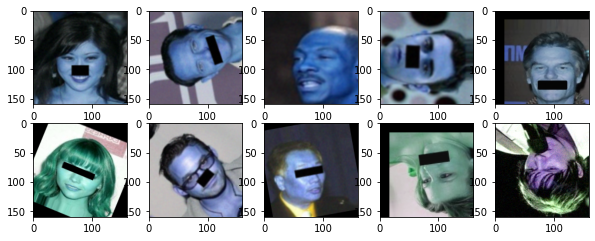

In [ ]:
path=celebA_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size
count = 1

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)
  save_file_name = f"/content/CelebA_Augmented/0_CelebA_{count}.jpg"
  cv2.imwrite(save_file_name, aug)
  count+=1
  print(save_file_name)

plt.show()

In [ ]:
from google.colab import files
import os

# Format for below line -->
# !zip -r /content/final_Folder_name.zip /content/Folder_to_be_zipped

!zip -r /content/CelebA_Augmented.zip /content/CelebA_Augmented

  adding: content/CelebA_Augmented/ (stored 0%)
  adding: content/CelebA_Augmented/0_CelebA_9.jpg (deflated 5%)
  adding: content/CelebA_Augmented/0_CelebA_5.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_6.jpg (deflated 4%)
  adding: content/CelebA_Augmented/0_CelebA_7.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_8.jpg (deflated 3%)
  adding: content/CelebA_Augmented/0_CelebA_4.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_3.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_1.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_10.jpg (deflated 2%)
  adding: content/CelebA_Augmented/0_CelebA_2.jpg (deflated 2%)


####FFHQ

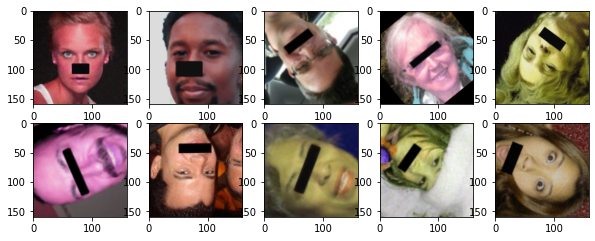

In [ ]:
path=ffhq_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####ATTGAN

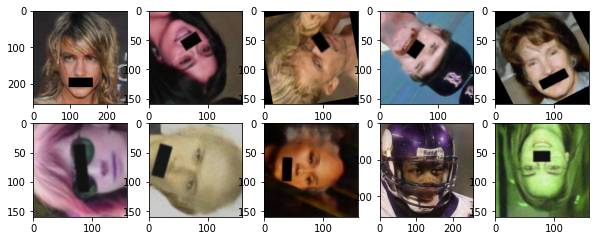

In [ ]:
path=attgan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####GDWCT

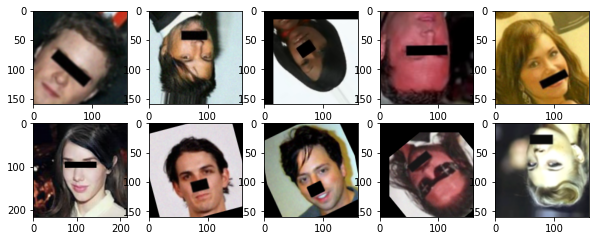

In [ ]:
path=gdwct_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####StyleGAN

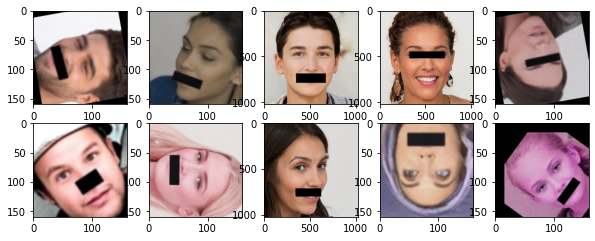

In [ ]:
path=stylegan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####StyleGAN2

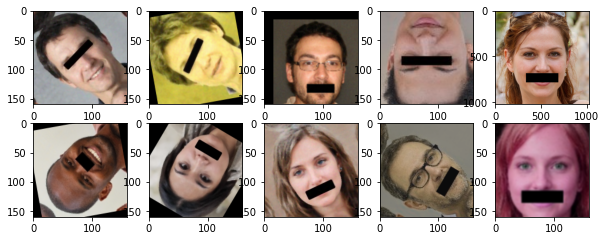

In [ ]:
path=stylegan2_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####StarGAN

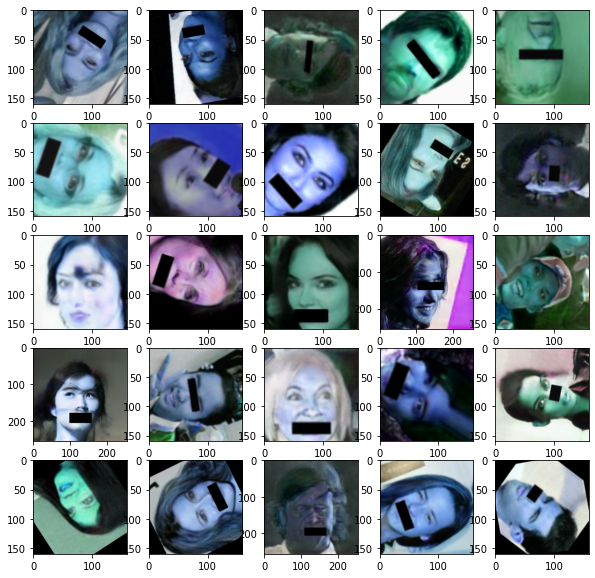

In [ ]:
path=stargan_path + "/"
files=os.listdir(path)
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
  d=random.choice(files)
  img = cv2.imread(path + f"{d}")
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(5,5,i+1)
  boxes, probs, landmarks = mtcnn_params(img)
  new_img = blackout(img, boxes, probs, landmarks)
  aug = transform(image = new_img)["image"]
  plt.imshow(aug)

plt.show()

####OUTCOME

*   Realised blurring was happening very less, so increased probability of blur
*   Likewise, increased probability of rotate as well
*   **If working** with single folder, try to analyse on as many different images as possible, each GAN has different quality of images and adjust pipeline accordingly!



#Augmenting AttGAN Folder with Albumentations (Complete)

###Creating Augmented images and saving to "AttGAN_Augmented" folder that I created

In [ ]:
path=attgan_path + "/"  #The path from which we want to read the images---> change accordingly
files=os.listdir(path)  #Gives list of all files(images) in that folder--->no change required
COUNT = 1 # this variable will be used in naming of augmented images while saving--->no change required

for file in files:  #no change required for these 5 lines
  img = cv2.imread(path + f"{file}")  #reading the file
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) NO NEED TO CONVERT BGR TO RGB
  boxes, probs, landmarks = mtcnn_params(img)  #getting landmarks of face
  new_img = blackout(img, boxes, probs, landmarks) #applying blackout on the image

#-------------Augmenting images from the blackout image we just created-------------------------------------------#

  for i in range(6):  # 3--> for real, 6--> for deepfake

#------------applying transformations using Albumentations (Main Transform pipeline)-------------------------------#
#--------------------only this part of code will be different for Keras Team---------------------------------------#

    transform = A.Compose([   #Change the pipeline to what you feel best suits your folder. Avoid too much augmentations
      A.Resize(160, 160, p=1),
      A.ImageCompression(quality_lower = 70, quality_upper=100, p=0.7),
      A.GaussNoise(p=0.4),
      A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
      A.Flip(p = 0.6),

      A.OneOf([
        A.GaussianBlur(blur_limit=3, sigma_limit=0, p=0.7),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.3),
      ], p = 0.5),

      A.OneOf([
        A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.7),
        A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.3),
      ], p = 0.7),

      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.25),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.25), 
      ], p = 0.6),  

    ], p = 0.9)
#-------------------------applying transform on blackout img-----------------------------------------------#

    aug = transform(image = new_img)["image"]  #the augmented image-->no change required
    
#-------------------------SAVING EACH IMAGE TO 'AttGAN_Augmented' FOLDER-------------------------------------#

    folder_to_save_img = "/content/AttGAN_Augmented"  #Path of folder you created  ---> Change this accordingly
    name_of_augmented_file = f"1_AttGAN_A_{COUNT}.jpg"  #Naming convention to be followed --> Change this accordingly, only 0/1 and celebA and whether A or K need to be changed
    
    cv2.imwrite(f"{folder_to_save_img}/{name_of_augmented_file}", aug) #saving the augmented image--> no change required
    COUNT+=1   #updating the count of img-->no change required


print(f"Total number of images augmented are {COUNT-1}")

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Total number of images augmented are 6001


##Splitting the files into train, val and test
###**First create 3 more folders**
1. AttGAN_Aug_Train
2. AttGAN_Aug_Val
3. AttGAN_Aug_Test

In [ ]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = "/content/drive/MyDrive/StarGan_Augmented"   #change accordingly
train_dir = "/content/drive/MyDrive/StarGAN/StarGAN_Aug_Train"  #change accordingly
val_dir = "/content/drive/MyDrive/StarGAN/StarGAN_Aug_Val"     #change accordingly
test_dir = "/content/drive/MyDrive/StarGAN/StarGAN_Aug_Test"    #change accordingly

!rm -rf `find -type d -name .ipynb_checkpoints`

allFileNames = os.listdir(root_dir)
np.random.shuffle(allFileNames)

train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.8), int(len(allFileNames)*0.9)])


train_FileNames = [root_dir+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [root_dir+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [root_dir+'/' + name for name in test_FileNames.tolist()]


print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/val')
# os.makedirs(root_dir +'/test')

#Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, train_dir)

for name in val_FileNames:
    shutil.copy(name, val_dir)

for name in test_FileNames:
    shutil.copy(name, test_dir)

Total images:  6000
Training:  4800
Validation:  600
Testing:  600


###Creating Zip folder of all 3 folders created before
Can't download folder directly, so we have to create zip folder of each

In [ ]:
from google.colab import files
import os

# Format for below line -->
# !zip -r /content/final_Folder_name.zip /content/Folder_to_be_zipped

#change accordingly
!zip -r /content/StarGAN_Aug_Train.zip /content/drive/MyDrive/StarGAN/StarGAN_Aug_Train  #zipping train folder
!zip -r /content/StarGAN_Aug_Val.zip /content/drive/MyDrive/StarGAN/StarGAN_Aug_Val      #zipping val folder
!zip -r /content/StarGAN_Aug_Test.zip /content/drive/MyDrive/StarGAN/StarGAN_Aug_Test    #zipping test folder

Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_4394.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_5454.jpg (deflated 1%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_1343.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_4046.jpg (deflated 3%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_5826.jpg (deflated 1%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_2334.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_3759.jpg (deflated 1%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_5844.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_1273.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/StarGAN_Aug_Train/0_StarGAN_682.jpg (deflated 2%)
  adding: content/drive/MyDrive/StarGAN/

##Done!
Now download the 3 zip files (train, test, val) on your computer

#Augmenting GDWCT Folder with Albumentations (Complete)

###Creating Augmented images and saving to "GDWCT_Augmented" folder that I created

In [ ]:
path=gdwct_path + "/"  #The path from which we want to read the images---> change accordingly
files=os.listdir(path)  #Gives list of all files(images) in that folder--->no change required
COUNT = 1 # this variable will be used in naming of augmented images while saving--->no change required

for file in files:  #no change required for these 5 lines
  img = cv2.imread(path + f"{file}")  #reading the file
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) NO NEED TO CONVERT BGR TO RGB
  boxes, probs, landmarks = mtcnn_params(img)  #getting landmarks of face
  new_img = blackout(img, boxes, probs, landmarks) #applying blackout on the image

#-------------Augmenting images from the blackout image we just created-------------------------------------------#

  for i in range(6):  # 3--> for real, 6--> for deepfake

#------------applying transformations using Albumentations (Main Transform pipeline)-------------------------------#
#--------------------only this part of code will be different for Keras Team---------------------------------------#

    transform = A.Compose([   #Change the pipeline to what you feel best suits your folder. Avoid too much augmentations
      A.Resize(160, 160, p=1),
      A.ImageCompression(quality_lower = 70, quality_upper=100, p=0.7),
      A.GaussNoise(p=0.4),
      A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.6),
      A.Flip(p = 0.6),

      A.OneOf([
        A.GaussianBlur(blur_limit=3, sigma_limit=0, p=0.7),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.3),
      ], p = 0.5),

      A.OneOf([
        A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.8),
        A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.4),
      ], p = 0.75),

      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.3),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.3), 
      ], p = 0.65),  

    ], p = 0.9)
#-------------------------applying transform on blackout img-----------------------------------------------#

    aug = transform(image = new_img)["image"]  #the augmented image-->no change required
    
#-------------------------SAVING EACH IMAGE TO 'AttGAN_Augmented' FOLDER-------------------------------------#

    folder_to_save_img = "/content/GDWCT_Augmented"  #Path of folder you created  ---> Change this accordingly
    name_of_augmented_file = f"1_GDWCT_A_{COUNT}.jpg"  #Naming convention to be followed --> Change this accordingly, only 0/1 and celebA and whether A or K need to be changed
    
    cv2.imwrite(f"{folder_to_save_img}/{name_of_augmented_file}", aug) #saving the augmented image--> no change required
    COUNT+=1   #updating the count of img-->no change required


print(f"Total number of images augmented are {COUNT-1}")

Total number of images augmented are 6000


##Splitting the files into train, val and test
###**First create 3 more folders**
1. GDWCT_Aug_Train
2. GDWCT_Aug_Val
3. GDWCT_Aug_Test

In [ ]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = '/content/GDWCT_Augmented'  #change accordingly
train_dir = "/content/GDWCT_Aug_Train" #change accordingly
val_dir = "/content/GDWCT_Aug_Val"     #change accordingly
test_dir = "/content/GDWCT_Aug_Test"   #change accordingly

!rm -rf `find -type d -name .ipynb_checkpoints`

allFileNames = os.listdir(root_dir)
np.random.shuffle(allFileNames)

train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.8), int(len(allFileNames)*0.9)])


train_FileNames = [root_dir+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [root_dir+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [root_dir+'/' + name for name in test_FileNames.tolist()]


print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/val')
# os.makedirs(root_dir +'/test')

#Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, train_dir)

for name in val_FileNames:
    shutil.copy(name, val_dir)

for name in test_FileNames:
    shutil.copy(name, test_dir)

Total images:  6000
Training:  4800
Validation:  600
Testing:  600


###Creating Zip folder of all 3 folders created before
Can't download folder directly, so we have to create zip folder of each

In [ ]:
from google.colab import files
import os

# Format for below line -->
# !zip -r /content/final_Folder_name.zip /content/Folder_to_be_zipped

#change accordingly
!zip -r /content/GDWCT_Aug_Train.zip /content/GDWCT_Aug_Train  #zipping train folder
!zip -r /content/GDWCT_Aug_Val.zip /content/GDWCT_Aug_Val      #zipping val folder
!zip -r /content/GDWCT_Aug_Test.zip /content/GDWCT_Aug_Test    #zipping test folder

Streaming output truncated to the last 5000 lines.
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_3402.jpg (deflated 1%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_3831.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_1519.jpg (deflated 1%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_5641.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_4706.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_936.jpg (deflated 1%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_2757.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_2220.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_1592.jpg (deflated 3%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_5539.jpg (deflated 3%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_511.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_5787.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_4727.jpg (deflated 2%)
  adding: content/GDWCT_Aug_Train/1_GDWCT_A_3322.jpg (deflated 1%)
  adding: con

##Done!
Now download the 3 zip files (train, test, val) on your computer

#Augmenting CelebA Folder with Albumentations (Complete)

###Creating Augmented images and saving to "CelebA_Augmented" folder that I created

In [ ]:
path=celebA_path + "/"  #The path from which we want to read the images---> change accordingly
files=os.listdir(path)  #Gives list of all files(images) in that folder--->no change required
COUNT = 1 # this variable will be used in naming of augmented images while saving--->no change required

for file in files:  #no change required for these 5 lines
  img = cv2.imread(path + f"{file}")  #reading the file
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) NO NEED TO CONVERT BGR TO RGB
  boxes, probs, landmarks = mtcnn_params(img)  #getting landmarks of face
  new_img = blackout(img, boxes, probs, landmarks) #applying blackout on the image

#-------------Augmenting images from the blackout image we just created-------------------------------------------#

  for i in range(3):  # 3--> for real, 6--> for deepfake

#------------applying transformations using Albumentations (Main Transform pipeline)-------------------------------#
#--------------------only this part of code will be different for Keras Team---------------------------------------#

    transform = A.Compose([   #Change the pipeline to what you feel best suits your folder. Avoid too much augmentations
      A.Resize(160, 160, p=1),
      A.ImageCompression(quality_lower = 70, quality_upper=100, p=0.7),
      A.GaussNoise(p=0.5),
      A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
      A.Flip(p = 0.6),

      A.OneOf([
        A.GaussianBlur(blur_limit=3, sigma_limit=0, p=0.7),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.3),
      ], p = 0.6),

      A.OneOf([
        A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.8),
        A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.4),
      ], p = 0.6),

      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.6),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.3),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.3), 
      ], p = 0.6),  

    ], p = 0.9)
#-------------------------applying transform on blackout img-----------------------------------------------#

    aug = transform(image = new_img)["image"]  #the augmented image-->no change required
    
#-------------------------SAVING EACH IMAGE TO 'AttGAN_Augmented' FOLDER-------------------------------------#

    folder_to_save_img = "/content/CelebA_Augmented"  #Path of folder you created  ---> Change this accordingly
    name_of_augmented_file = f"0_CelebA_A_{COUNT}.jpg"  #Naming convention to be followed --> Change this accordingly, only 0/1 and celebA and whether A or K need to be changed
    
    cv2.imwrite(f"{folder_to_save_img}/{name_of_augmented_file}", aug) #saving the augmented image--> no change required
    COUNT+=1   #updating the count of img-->no change required


print(f"Total number of images augmented are {COUNT-1}")

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Total number of images augmented are 15000


##Splitting the files into train, val and test
###**First create 3 more folders**
1. CelebA_Aug_Train
2. CelebA_Aug_Val
3. CelebA_Aug_Test

In [ ]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = '/content/CelebA_Augmented'   #change accordingly
train_dir = "/content/CelebA_Aug_Train"  #change accordingly
val_dir = "/content/CelebA_Aug_Val"      #change accordingly
test_dir = "/content/CelebA_Aug_Test"    #change accordingly

!rm -rf `find -type d -name .ipynb_checkpoints`

allFileNames = os.listdir(root_dir)
np.random.shuffle(allFileNames)

train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.8), int(len(allFileNames)*0.9)])


train_FileNames = [root_dir+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [root_dir+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [root_dir+'/' + name for name in test_FileNames.tolist()]


print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/val')
# os.makedirs(root_dir +'/test')

#Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, train_dir)

for name in val_FileNames:
    shutil.copy(name, val_dir)

for name in test_FileNames:
    shutil.copy(name, test_dir)

Total images:  15000
Training:  12000
Validation:  1500
Testing:  1500


###Creating Zip folder of all 3 folders created before
Can't download folder directly, so we have to create zip folder of each

In [ ]:
from google.colab import files
import os

# Format for below line -->
# !zip -r /content/final_Folder_name.zip /content/Folder_to_be_zipped

#change accordingly
!zip -r /content/CelebA_Aug_Train.zip /content/CelebA_Aug_Train  #zipping train folder
!zip -r /content/CelebA_Aug_Val.zip /content/CelebA_Aug_Val      #zipping val folder
!zip -r /content/CelebA_Aug_Test.zip /content/CelebA_Aug_Test    #zipping test folder

Streaming output truncated to the last 5000 lines.
  adding: content/CelebA_Aug_Train/0_CelebA_A_5511.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_7981.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_9293.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_11493.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_8205.jpg (deflated 3%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_8160.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_13970.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_5002.jpg (deflated 3%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_14038.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_4791.jpg (deflated 3%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_7962.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_2642.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_747.jpg (deflated 2%)
  adding: content/CelebA_Aug_Train/0_CelebA_A_5892